# 用PCA降维

本章我们将介绍一种降维方法，PCA（Principal Component Analysis，主成分分析）。降维致力于解决三类问题。第一，降维可以缓解维度灾难问题。第二，降维可以在压缩数据的同时让信息损失最小化。第三，理解几百个维度的数据结构很困难，两三个维度的数据通过可视化更容易理解。下面，我们用PCA将一个高维数据降成二维，方便可视化，之后，我们建一个脸部识别系统。

<!-- TEASER_END-->

## PCA简介

在*第三章，特征提取与处理*里面，涉及高维特征向量的问题往往容易陷入维度灾难。随着数据集维度的增加，算法学习需要的样本数量呈指数级增加。有些应用中，遇到这样的大数据是非常不利的，而且从大数据集中学习需要更多的内存和处理能力。另外，随着维度的增加，数据的稀疏性会越来越高。在高维向量空间中探索同样的数据集比在同样稀疏的数据集中探索更加困难。

主成分分析也称为卡尔胡宁-勒夫变换（Karhunen-Loeve Transform），是一种用于探索高维数据结构的技术。PCA通常用于高维数据集的探索与可视化。还可以用于数据压缩，数据预处理等。PCA可以把可能具有相关性的高维变量合成线性无关的低维变量，称为主成分（ principal components）。新的低维数据集会尽可能的保留原始数据的变量。

PCA将数据投射到一个低维子空间实现降维。例如，二维数据集降维就是把点投射成一条线，数据集的每个样本都可以用一个值表示，不需要两个值。三维数据集可以降成二维，就是把变量映射成一个平面。一般情况下，$n$维数据集可以通过映射降成$k$维子空间，其中$k<n$。更专业的说法是，PCA可以用来找到一组表示子空间的矢量，这组矢量是映射数据的误差的平方和最小化的结果。

假如你是一本养花工具宣传册的摄影师，你正在拍摄一个水壶。水壶是三维的，但是照片是二维的，为了更全面的把水壶展示给客户，你需要从不同角度拍几张图片。下图是你从四个方向拍的照片：

![wateringcan](mlslpic/7.1 wateringcan.png)

第一张图里水壶的背面可以看到，但是看不到前面。第二张图是拍前面，可以看到壶嘴，这张图可以提供了第一张图缺失的信息，但是壶把看不到了。从第三张俯视图里无法看出壶的高度。第四张图是你打算放进目录的，水壶的高度，顶部，壶嘴和壶把都清晰可见。

PCA的设计理念与此类似，它可以将高维数据集映射到低维空间的同时，尽可能的保留更多变量。PCA旋转数据集与其主成分对齐，将最多的变量保留到第一主成分中。假设我们有下图所示的数据集：

![dataset](mlslpic/7.2 dataset.png)

数据集看起来像一个从原点到右上角延伸的细长扁平的椭圆。要降低整个数据集的维度，我们必须把点映射成一条线。下图中的两条线都是数据集可以映射的，映射到哪条线样本变化最大？

![datasetline](mlslpic/7.3 datasetline.png)

显然，样本映射到虚线的变化比映射到点线的变化大。实际上，这条虚线就是第一主成分。第二主成分必须与第一主成分正交，也就是说第二主成分必须是在统计学上独立的，会出现在与第一主成分垂直的方向，如下图所示：

![orthogonal](mlslpic/7.4 orthogonal.png)

后面的每个主成分也会尽量多的保留剩下的变量，唯一的要求就是每一个主成分需要和前面的主成分正交。

现在假设数据集是三维的，散点图看起来像是沿着一个轴旋转的光盘。

![threedimensional](mlslpic/7.5 threedimensional.png)

这些点可以通过旋转和变换使光盘完全变成二维的。现在这些点看着像一个椭圆，第三维上基本没有变量，可以被忽略。

当数据集不同维度上的方差分布不均匀的时候，PCA最有用。如果是一个三维的球状(spherical convex hull)数据集，PCA不能有效的发挥作用，因为各个方向上的方差都相等；没有任何一个信息维度可以被忽略而不丢失大量的信息。

## PCA计算步骤

在介绍PCA的运行步骤之前，有一些术语需要说明一下。

### 方差，协方差和协方差矩阵

方差（Variance）是度量一组数据分散的程度。方差是各个样本与样本均值的差的平方和的均值：

$$s^2 = \frac {\sum_{i=1}^n {{(X_i-\bar X)}^2}} {n-1}$$

协方差（Covariance）是度量两个变量的变动的同步程度，也就是度量两个变量线性相关性程度。如果两个变量的协方差为0，则统计学上认为二者线性无关。注意两个无关的变量并非完全独立，只是没有线性相关性而已。计算公式如下：

$$cov(X,Y)=\frac {\sum_{i=1}^n {(X_i-\bar X)(Y_i-\bar y)}} {n-1}$$

如果协方差不为0，大于0表示正相关，小于0表示负相关。当协方差大于0时，一个变量增大是另一个变量也会增大。当协方差小于0时，一个变量增大是另一个变量会减小。协方差矩阵（Covariance matrix）由数据集中两两变量的协方差组成。矩阵的第$(i,j)$个元素是数据集中第$i$和第$j$个元素的协方差。例如，三维数据的协方差矩阵如下所示：

$$
C=
\begin{bmatrix}
cov(x_1,x_1) & cov(x_1,x_2) & cov(x_1,x_3)\\
cov(x_2,x_1) & cov(x_2,x_2) & cov(x_2,x_3)\\
cov(x_3,x_1) & cov(x_3,x_2) & cov(x_3,x_3)\\
\end{bmatrix}
$$

让我们计算下表数据的协方差矩阵：

| X1 | X2 | X3 |
| :-: | :-: | :-: |
| 2 | 0 | −1.4 |
| 2.2 | 0.2 | −1.5 |
| 2.4 | 0.1 | −1 |
| 1.9 | 0 | −1.2 |

三个变量的样本均值分别是2.125，0.075和-1.275。用Numpy计算协方差矩阵如下：

In [1]:
import numpy as np
X = [[2, 0, -1.4],
    [2.2, 0.2, -1.5],
    [2.4, 0.1, -1],
    [1.9, 0, -1.2]]
print(np.cov(np.array(X).T))

[[ 0.04916667  0.01416667  0.01916667]
 [ 0.01416667  0.00916667 -0.00583333]
 [ 0.01916667 -0.00583333  0.04916667]]


### 特征向量和特征值

向量是具有大小（magnitude）和方向（direction）的几何概念。一个矩阵的特征向量（eigenvector）是满足如下公式的非零向量：

$$A \vec \nu = \lambda \vec \nu$$

其中，$\vec \nu$是特征向量，$A$是方阵，$\lambda$是特征值。经过$A$变换之后，特征向量的方向保持不变，只是其大小发生了特征值倍数的变化。也就是说，一个特征向量左乘一个矩阵之后等于等比例放缩（scaling）特征向量。德语单词*eigen*的意思是*属于...或...专有（ belonging to or peculiar to）*；矩阵的特征向量是属于并描述数据集结构的向量。

特征向量和特征值只能由方阵得出，且并非所有方阵都有特征向量和特征值。如果一个矩阵有特征向量和特征值，那么它的每个维度都有一对特征向量和特征值。矩阵的主成分是其协方差矩阵的特征向量，按照对应的特征值大小排序。最大的特征值就是第一主成分，第二大的特征值就是第二主成分，以此类推。

让我们来计算下面矩阵的特征向量和特征值：

$$A=
\begin{bmatrix}
1 & -2 \\
2 & -3 \\
\end{bmatrix}
$$

根据前面的公式$A$乘以特征向量，必然等于特征值乘以特征向量。我们建立特征方程求解：

$$(A- \lambda I) \vec \nu=0$$

$$|A-\lambda * I| = 
\begin{vmatrix}
\begin{bmatrix}
1 & -2 \\
2 & -3 \\
\end{bmatrix}
-
\begin{bmatrix}
\lambda & 0 \\
0 & \lambda \\
\end{bmatrix}
\end{vmatrix}
= 0
$$

从特征方程可以看出，矩阵与单位矩阵和特征值乘积的矩阵行列式为0：

$$
\begin{vmatrix}
\begin{bmatrix}
1-\lambda & -2 \\
2 & -3-\lambda \\
\end{bmatrix}
\end{vmatrix}
=(\lambda+1)(\lambda+1)
= 0
$$

矩阵的两个特征值都等于-1。现在再用特征值来解特征向量。

$$A \vec \nu = \lambda \vec \nu$$

首先，我们用特征方程：

$$(A- \lambda I) \vec \nu=0$$

把数据带入：

$$
\begin{pmatrix}
\begin{bmatrix}
1 & -2 \\
2 & -3 \\
\end{bmatrix}
-
\begin{bmatrix}
\lambda & 0 \\
0 & \lambda \\
\end{bmatrix}
\end{pmatrix}
\vec \nu
=
\begin{bmatrix}
1-\lambda & -2 \\
2 & -3-\lambda \\
\end{bmatrix}
\vec \nu
=
\begin{bmatrix}
1-\lambda & -2 \\
2 & -3-\lambda \\
\end{bmatrix}
\begin{bmatrix}
\nu_{1,1} \\
\nu_{1,2} \\
\end{bmatrix}
=0
$$

我们把特征值代入方程：

$$\begin{bmatrix}
1-(-1) & -2 \\
2 & -3-(-1) \\
\end{bmatrix}
\begin{bmatrix}
\nu_{1,1} \\
\nu_{1,2} \\
\end{bmatrix}
=
\begin{bmatrix}
2 & -2 \\
2 & -2 \\
\end{bmatrix}
\begin{bmatrix}
\nu_{1,1} \\
\nu_{1,2} \\
\end{bmatrix}
=0
$$

可以重新整理成如下方程：

\begin{Bmatrix}
2\nu_{1,1} + -(2\nu_{1,2})=0 \\
2\nu_{1,1} + -(2\nu_{1,2})=0 \\
\end{Bmatrix}

任何满足方程的非零向量都可以作为特征向量：
$$
\begin{bmatrix}
1 & -2 \\
2 & -3 \\
\end{bmatrix}
\begin{bmatrix}
1 \\
1 \\
\end{bmatrix}
=
\begin{bmatrix}
1 \\
1 \\
\end{bmatrix}
=
\begin{bmatrix}
-1 \\
-1 \\
\end{bmatrix}
$$

PCA需要单位特征向量，也就是L2范数等于1的特征向量：

$$
\begin{Vmatrix}
x \\
\end{Vmatrix}
=
\sqrt {x_1^2 + x_2^2 + \dots + x_n^2}
$$

那么把前面的特征向量带入可得：

$$
\begin{Vmatrix}
\begin{bmatrix}
1 \\
1 \\
\end{bmatrix}
\end{Vmatrix}
=
\sqrt {1^2+1^2}
=
\sqrt 2
$$

于是单位特征向量是：

$$
\begin{bmatrix}
1 \\
1 \\
\end{bmatrix} / {\sqrt 2}
=
\begin{bmatrix}
0.70710678 \\
0.70710678 \\
\end{bmatrix}
$$

我们可以通过Numpy检验我们手算的特征向量。`eig`函数返回特征值和特征向量的元组：

In [2]:
import numpy as np
w, v = np.linalg.eig(np.array([[1, -2], [2, -3]]))
print('特征值：{}\n特征向量：{}'.format(w,v))

特征值：[-0.99999998 -1.00000002]
特征向量：[[ 0.70710678  0.70710678]
 [ 0.70710678  0.70710678]]


### 用PCA降维

让我们用PCA方法把下表二维数据降成一维：

| X1 | X2|
| :-: | :-: |
|0.9 | 1|
|2.4 | 2.6|
|1.2 | 1.7|
|0.5 | 0.7|
|0.3 | 0.7|
|1.8 | 1.4|
|0.5 | 0.6|
|0.3 | 0.6|
|2.5 | 2.6|
|1.3 | 1.1|

PCA第一步是用解释变量减去样本均值：

| X1 | X2|
| :-: | :-: |
|0.9 - 1.17 = -0.27 | 1 - 1.3 = -0.3|
|2.4 - 1.17 = 1.23 | 2.6 - 1.3 = 1.3|
|1.2 - 1.17 = 0.03 | 1.7 - 1.3 = 0.4|
|0.5 - 1.17 = -0.67 | -0.7 - 1.3 = 0.6|
|0.3 - 1.17 = -0.87 | -0.7 - 1.3 = 0.6|
|1.8 - 1.17 = 0.63 | 1.4 - 1.3 = 0.1|
|0.5 - 1.17 = -0.67 | 0.6 - 1.3 = -0.7|
|0.3 - 1.17 = -0.87 | 0.6 - 1.3 = -0.7|
|2.5 - 1.17 = 1.33 | 2.6 - 1.3 = 1.3|
|1.3 - 1.17 = 0.13 | 1.1 - 1.3 = -0.2|

然后，我们计算数据的主成分。前面介绍过，矩阵的主成分是其协方差矩阵的特征向量，按照对应的特征值大小排序。主成分可以通过两种方法计算。第一种方法是计算数据协方差矩阵。因为协方差矩阵是方阵，所有我们可以用前面的方法计算特征值和特征向量。第二种方法是用数据矩阵的奇异值分解（singular value decomposition）来找协方差矩阵的特征向量和特征值的平方根。我们先介绍第一种方法，然后介绍scikit-learn的PCA实现，也就是第二种方法。上述数据集的解释变量协方差矩阵如下：

$$
C=
\begin{bmatrix}
0.6867777778 & 0.6066666667 \\
0.6066666667 & 0.5977777778 \\
\end{bmatrix}
$$

用前面介绍过的方法，特征值是1.250和0.034，单位特征向量是：

$$
\begin{bmatrix}
0.73251454 & 0.68075138 \\
0.68075138 & 0.73251454 \\
\end{bmatrix}
$$

下面我们把数据映射到主成分上。第一主成分是最大特征值对应的特征向量，因此我们要建一个转换矩阵，它的每一列都是主成分的特征向量。如果我们要把5维数据降成3维，那么我们就要用一个3维矩阵做转换矩阵。在本例中，我们将把我们的二维数据映射成一维，因此我们只需要用特征向量中的第一主成分。最后，我们用数据矩阵点乘转换矩阵。下面就是第一主成分映射的结果：

$$
\begin{bmatrix}
-0.27 & -0.3 \\
1.23 & 1.3 \\
0.03 & 0.4 \\
-0.67 & 0.6 \\
-0.87 & 0.6 \\
0.63 & 0.1 \\
-0.67 & -0.7 \\
-0.87 & -0.7 \\
1.33 & 1.3 \\
0.13 & -0.2 \\
\end{bmatrix}
\begin{bmatrix}
0.73251454 \\
0.68075138 \\
\end{bmatrix}
=
\begin{bmatrix}
-0.40200434 \\
 1.78596968 \\
 0.29427599 \\
-0.08233391 \\
-0.22883682 \\
 0.5295593  \\
-0.96731071 \\
-1.11381362 \\
 1.85922113 \\
-0.04092339 \\
\end{bmatrix}
$$

通过Numpy的`dot`函数计算如下：

In [3]:
a = [[-0.27, -0.3],
[1.23, 1.3],
[0.03, 0.4],
[-0.67, 0.6],
[-0.87, 0.6],
[0.63, 0.1],
[-0.67, -0.7],
[-0.87, -0.7],
[1.33, 1.3],
[0.13, -0.2]]

b = [[0.73251454], [0.68075138]]

np.dot(a,b)

array([[-0.40200434],
       [ 1.78596968],
       [ 0.29427599],
       [-0.08233391],
       [-0.22883682],
       [ 0.5295593 ],
       [-0.96731071],
       [-1.11381362],
       [ 1.85922113],
       [-0.04092339]])

许多PCA的实现方法，包括scikit-learn的实现方法都是用奇异值分解计算特征值和特征向量。SVD计算公式如下：

$$X=U \sum {V^T}$$

列向量$U$称为数据矩阵的左奇异值向量，$V$称为数据矩阵的右奇异值向量，$\sum$的对角线元素是它的奇异值。矩阵的奇异值向量和奇异值在一些信号处理和统计学中是十分有用的，我们只对它们与数据矩阵特征向量和特征值相关的内容感兴趣。具体来说，左奇异值向量就是协方差矩阵的特征向量，$\sum$的对角线元素是协方差矩阵的特征值的平方根。计算SVD超出本书范围，不过用SVD找特征向量的方法与通过协方差矩阵解析方法类似，详细内容见线性代数教程。

## 用PCA实现高维数据可视化

二维或三维数据更容易通过可视化发现模式。一个高维数据集是无法用图形表示的，但是我们可以通过降维方法把它降成二维或三维数据来可视化。

Fisher1936年收集了三种鸢尾花分别50个样本数据（Iris Data）：Setosa、Virginica、Versicolour。解释变量是花瓣（petals）和萼片（sepals）长度和宽度的测量值，响应变量是花的种类。鸢尾花数据集经常用于分类模型测试，scikit-learn中也有。让我们把`iris`数据集降成方便可视化的二维数据：

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris

首先，我们导入鸢尾花数据集和`PCA`估计器。`PCA`类把主成分的数量作为超参数，和其他估计器一样，`PCA`也用`fit_transform()`返回降维的数据矩阵：

In [5]:
data = load_iris()
y = data.target
X = data.data
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(X)

最后，我们把图形画出来：

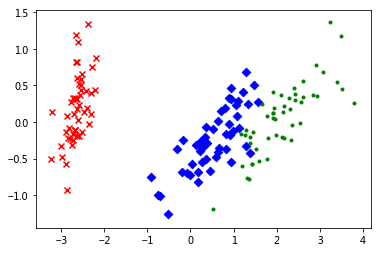

In [6]:
red_x, red_y = [], []
blue_x, blue_y = [], []
green_x, green_y = [], []

for i in range(len(reduced_X)):
    if y[i] == 0:
        red_x.append(reduced_X[i][0])
        red_y.append(reduced_X[i][1])
    elif y[i] == 1:
        blue_x.append(reduced_X[i][0])
        blue_y.append(reduced_X[i][1])
    else:
        green_x.append(reduced_X[i][0])
        green_y.append(reduced_X[i][1])

plt.scatter(red_x, red_y, c='r', marker='x')
plt.scatter(blue_x, blue_y, c='b', marker='D')
plt.scatter(green_x, green_y, c='g', marker='.')
plt.show()

降维的数据如上图所示。每个数据集中三个类都用不同的符号标记。从这个二维数据图中可以明显看出，有一个类与其他两个重叠的类完全分离。这个结果可以帮助我们选择分类模型。

## PCA脸部识别

现在让我们用PCA来解决一个脸部识别问题。脸部识别是一个监督分类任务，用于从照片中认出某个人。本例中，我们用剑桥大学AT&T实验室的[Our Database of Faces数据集](http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html)，这个数据集包含40个人每个人10张照片。这些照片是在不同的光照条件下拍摄的，每张照片的表情也不同。照片都是黑白的，尺寸为92 x 112像素。虽然这些图片都不大，但是每张图片的按像素强度排列的特征向量也有10304维。这些高维数据的训练可能需要很多样本才能避免拟合过度。而我们样本量并不大，所有我们用PCA计算一些主成分来表示这些照片。

我们可以把照片的像素强度矩阵转换成向量，然后用所有的训练照片的向量建一个矩阵。每个照片都是数据集主成分的线性组合。在脸部识别理论中，这些主成分称为特征脸（eigenfaces）。特征脸可以看成是脸部的标准化组成部分。数据集中的每张脸都可以通过一些标准脸的组合生成出来，或者说是最重要的特征脸线性组合的近似值。

In [7]:
from os import walk, path
import numpy as np
import mahotas as mh
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = []
y = []

下面我们把照片导入`Numpy`数组，然后把它们的像素矩阵转换成向量：

In [8]:
for dir_path, dir_names, file_names in walk('mlslpic/att-faces/'):
    for fn in file_names:
        if fn[-3:] == 'pgm':
            image_filename = path.join(dir_path, fn)
            X.append(scale(mh.imread(image_filename, as_grey=True).reshape(10304).astype('float32')))
            y.append(dir_path)

X = np.array(X)

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


然后，我们用交叉检验建立训练集和测试集，在训练集上用`PCA：`

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
pca = PCA(n_components=150)

我们把所有样本降到150维，然后训练一个逻辑回归分类器。数据集包括40个类；scikit-learn底层会自动用one versus all策略创建二元分类器：

In [10]:
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)
print('训练集数据的原始维度是：{}'.format(X_train.shape))
print('PCA降维后训练集数据是：{}'.format(X_train_reduced.shape))
classifier = LogisticRegression()
accuracies = cross_val_score(classifier, X_train_reduced, y_train)

训练集数据的原始维度是：(300, 10304)
PCA降维后训练集数据是：(300, 150)


最后，我们用交叉验证和测试集评估分类器的性能。分类器的平均综合评价指标（F1 score）是0.88，但是需要花费更多的时间训练，在更多训练实例的应用中可能会更慢。

In [11]:
print('交叉验证准确率是：{}\n{}'.format(np.mean(accuracies), accuracies))
classifier.fit(X_train_reduced, y_train)
predictions = classifier.predict(X_test_reduced)
print(classification_report(y_test, predictions))

交叉验证准确率是：0.8341017316017316
[ 0.84821429  0.87        0.78409091]
                       precision    recall  f1-score   support

 mlslpic/att-faces/s1       1.00      1.00      1.00         1
mlslpic/att-faces/s10       1.00      1.00      1.00         1
mlslpic/att-faces/s11       0.67      1.00      0.80         2
mlslpic/att-faces/s12       1.00      1.00      1.00         3
mlslpic/att-faces/s13       1.00      1.00      1.00         1
mlslpic/att-faces/s14       1.00      1.00      1.00         3
mlslpic/att-faces/s15       1.00      1.00      1.00         4
mlslpic/att-faces/s16       1.00      1.00      1.00         3
mlslpic/att-faces/s17       1.00      1.00      1.00         2
mlslpic/att-faces/s18       0.50      1.00      0.67         1
mlslpic/att-faces/s19       0.00      0.00      0.00         1
 mlslpic/att-faces/s2       1.00      1.00      1.00         1
mlslpic/att-faces/s20       1.00      1.00      1.00         4
mlslpic/att-faces/s21       1.00      1.00      1.0

/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/linyong/anaconda/envs/pydata/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## 总结

本章，我们介绍了降维问题。高维数据不能轻易可视化。估计器训练高维数据集时，也可能出现维度灾难。我们通过主成分分析法缓解这些问题，将可能解释变量具有相关性的高维数据集，通过将数据映射到一个低维子空间，降维成一个线性无关的低维数据集。我们用主成分分析将四维的鸢尾花数据集降成二维数据进行可视化，还建立了一个脸部识别系统。下一章，我们将回到监督学习方法，介绍一种分类算法——感知器（perceptron），本书的最后两章都是建立在感知器的基础上。

> 感谢: 中文原文出处，[绿萝间](https://muxuezi.github.io)  
> 英文原版书: [Mastering Machine Learning with scikit-learn, Packet 2014](https://www.packtpub.com/mapt/book/big_data_and_business_intelligence/9781783988365)